# IMAGE DESCRIPTION

## Dataset Description

There are many open source datasets available for this problem, like Flickr 8k (containing8k images), Flickr 30k (containing 30k images), MS COCO (containing 180k images), etc. I have used the Flickr 8k dataset because it is a good starting dataset as it is small in size and can be trained easily on low-end laptops/desktops using a CPU.

Our dataset file structure is as follows:-

Flick8k/

Flick8k_Dataset/ :- contains the 8000 images

Flick8k_Text/
Flickr8k.token.txt:- contains the image id along with the 5 captions

These images are bifurcated as follows:

Training Set — 6000 images /
Dev Set — 1000 images /
Test Set — 1000 images

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
import string
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.backend import set_session
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [4]:
#The location of the Flickr8K_ photo
images_path = r"C:\Users\Bhanu Koushik\Downloads\DEEPLEARNING_DS\Flickr8k_Dataset/"
#The location of the caption file
token_path = r"C:\Users\Bhanu Koushik\Downloads\DEEPLEARNING_DS\Flickr8k_text\Flickr8k.token.txt"

In [6]:
text = open(token_path,'r').read()
print(text[:666])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring


### Building this raw zigzag text data into a proper dataframe

In [7]:
def build_dataframe(text):
    text_df=[]
    for sentences in text.split('\n'):
        splitted = sentences.split('\t')
        if len(splitted) == 1:
            continue
        w = splitted[0].split("#")
        text_df.append(w + [splitted[1].lower()])
    return text_df

In [8]:
text_df = build_dataframe(text)

In [9]:
text_df[:10]

[['1000268201_693b08cb0e.jpg',
  '0',
  'a child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', '1', 'a girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  '2',
  'a little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '3',
  'a little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '4',
  'a little girl in a pink dress going into a wooden cabin .'],
 ['1001773457_577c3a7d70.jpg',
  '0',
  'a black dog and a spotted dog are fighting'],
 ['1001773457_577c3a7d70.jpg',
  '1',
  'a black dog and a tri-colored dog playing with each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  '2',
  'a black dog and a white dog with brown spots are staring at each other in the street .'],
 ['1001773457_577c3a7d70.jpg',
  '3',
  'two dogs of different breeds looking at each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  '4',
  'two dogs on pavement moving t

In [10]:
caption_df = pd.DataFrame(text_df,columns=["filename","index","caption"])
caption_df = caption_df.reindex(columns =['index','filename','caption'])

In above cell we are creating a dataframe from raw data with columns named as index, filename,caption

In below cell we are just printing the dataframe 

In [11]:
caption_df

index                   filename  \
0         0  1000268201_693b08cb0e.jpg   
1         1  1000268201_693b08cb0e.jpg   
2         2  1000268201_693b08cb0e.jpg   
3         3  1000268201_693b08cb0e.jpg   
4         4  1000268201_693b08cb0e.jpg   
...     ...                        ...   
40455     0   997722733_0cb5439472.jpg   
40456     1   997722733_0cb5439472.jpg   
40457     2   997722733_0cb5439472.jpg   
40458     3   997722733_0cb5439472.jpg   
40459     4   997722733_0cb5439472.jpg   

                                                 caption  
0      a child in a pink dress is climbing up a set o...  
1                  a girl going into a wooden building .  
2       a little girl climbing into a wooden playhouse .  
3      a little girl climbing the stairs to her playh...  
4      a little girl in a pink dress going into a woo...  
...                                                  ...  
40455           a man in a pink shirt climbs a rock face  
40456           a man is rock climbing high in the air .  
40457  a person in a red shirt climbing up a rock fac...  
40458                    a rock climber in a red shirt .  
40459  a rock climber practices on a rock climbing wa...  

[40460 rows x 3 columns]

Now, we are just checking whether the caption_df is clean or not

In [12]:
# If any filename dosn't have .jpg extension at last then mark it as Invalid filename
def invalid_filename_check(data):
    for filenames in data["filename"]:
        found = re.search("(.(jpg)$)", filenames)
        if (found):
            pass
        else:
            print("wrong image name: {}".format(filenames))

In [13]:
invalid_filename_check(caption_df)

wrong image name: 2258277193_586949ec62.jpg.1
wrong image name: 2258277193_586949ec62.jpg.1
wrong image name: 2258277193_586949ec62.jpg.1
wrong image name: 2258277193_586949ec62.jpg.1
wrong image name: 2258277193_586949ec62.jpg.1


Thus, for making clean data we have to remove this odd filename

Below, lets see that in the dataframe

In [14]:
caption_df[caption_df['filename'] == "2258277193_586949ec62.jpg.1"]

index                     filename  \
6730     0  2258277193_586949ec62.jpg.1   
6731     1  2258277193_586949ec62.jpg.1   
6732     2  2258277193_586949ec62.jpg.1   
6733     3  2258277193_586949ec62.jpg.1   
6734     4  2258277193_586949ec62.jpg.1   

                                                caption  
6730                      people waiting for the subway  
6731  some people looking out windows in a large bui...  
6732     three people are waiting on a train platform .  
6733               three people standing at a station .  
6734  two woman and one man standing near train trac...

In [15]:
caption_df = caption_df[caption_df['filename'] != '2258277193_586949ec62.jpg.1']

In [16]:
caption_df.shape

(40455, 3)

Here we can see before there are 40460 rows and now we removed the above 5 rows.
Thus it is showing now the DF has 40455 rows

In [18]:
def utility_counter(caption_df):
    unique_filenames = np.unique(caption_df.filename.values)
    print("The number of unique file are : {}".format(len(unique_filenames)))

    ct_dict = Counter(caption_df.filename.values)
    print(ct_dict)
    print("We can see that all the keys are having values count = 5")

    print("The distribution of the number of captions for each image:")
    ct = Counter(Counter(caption_df.filename.values).values())
    print(ct)
    return unique_filenames

In [19]:
unique_filenames = utility_counter(caption_df)

The number of unique file are : 8091
Counter({'1000268201_693b08cb0e.jpg': 5, '1001773457_577c3a7d70.jpg': 5, '1002674143_1b742ab4b8.jpg': 5, '1003163366_44323f5815.jpg': 5, '1007129816_e794419615.jpg': 5, '1007320043_627395c3d8.jpg': 5, '1009434119_febe49276a.jpg': 5, '1012212859_01547e3f17.jpg': 5, '1015118661_980735411b.jpg': 5, '1015584366_dfcec3c85a.jpg': 5, '101654506_8eb26cfb60.jpg': 5, '101669240_b2d3e7f17b.jpg': 5, '1016887272_03199f49c4.jpg': 5, '1019077836_6fc9b15408.jpg': 5, '1019604187_d087bf9a5f.jpg': 5, '1020651753_06077ec457.jpg': 5, '1022454332_6af2c1449a.jpg': 5, '1022454428_b6b660a67b.jpg': 5, '1022975728_75515238d8.jpg': 5, '102351840_323e3de834.jpg': 5, '1024138940_f1fefbdce1.jpg': 5, '102455176_5f8ead62d5.jpg': 5, '1026685415_0431cbf574.jpg': 5, '1028205764_7e8df9a2ea.jpg': 5, '1030985833_b0902ea560.jpg': 5, '103106960_e8a41d64f8.jpg': 5, '103195344_5d2dc613a3.jpg': 5, '103205630_682ca7285b.jpg': 5, '1032122270_ea6f0beedb.jpg': 5, '1032460886_4a598ed535.jpg': 5, '

lets plot some images to see they are correctly mapped with their captions

In [20]:
def image_cap_plotter(data):     
    npic = 5
    npix = 224
    target_size = (npix,npix,3)

    count = 1
    fig = plt.figure(figsize=(10,20))
    for jpgfnm in unique_filenames[35:39]:       
        filename = images_path + '/' + jpgfnm
        captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
        image_load = load_img(filename, target_size=target_size)

        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

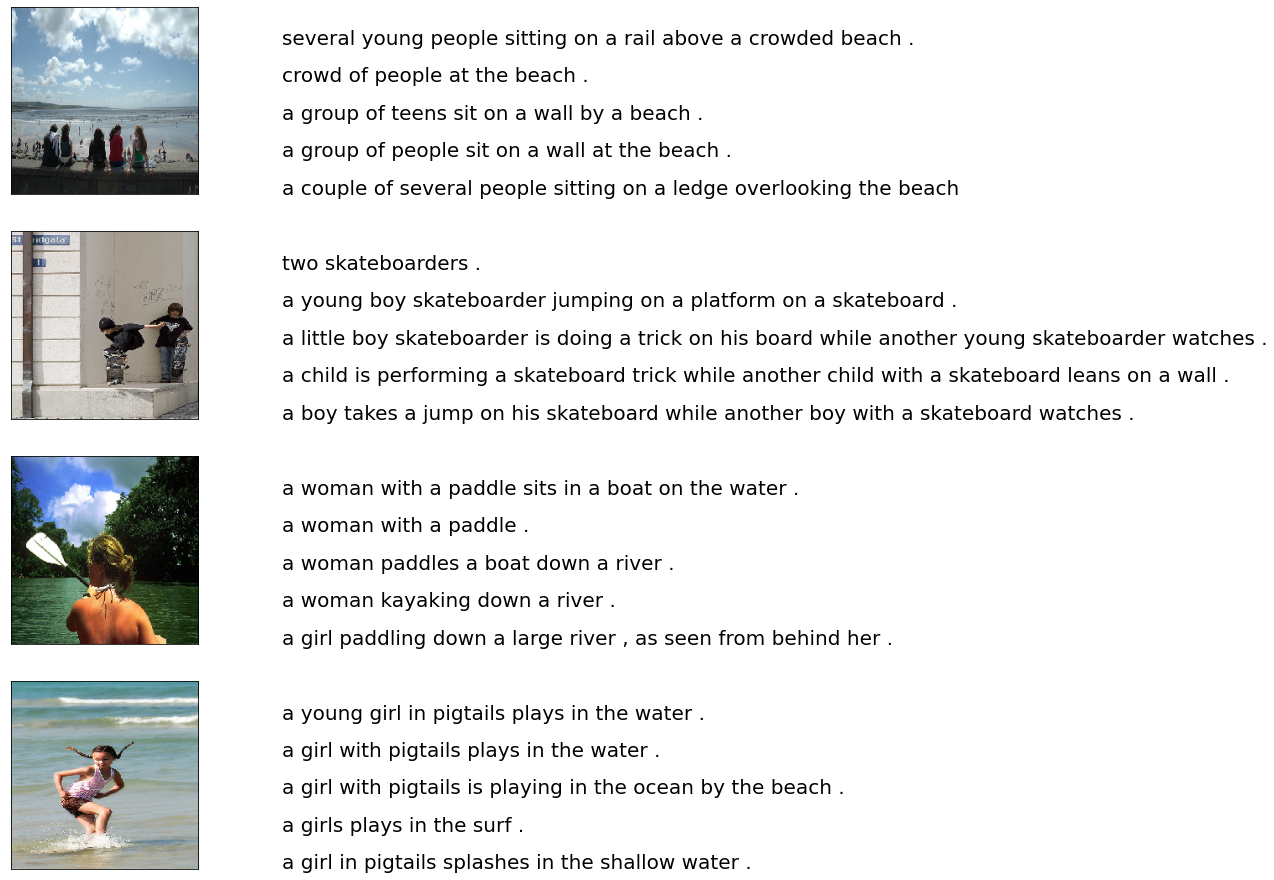

In [21]:
image_cap_plotter(caption_df)

Next let’s see what our current vocabulary size is:-

In [22]:
def create_vocabulary(data):
    vocab = []
    for captions in data.caption.values:
        vocab.extend(captions.split())
        
    print("Vocabulary Size : {}".format(len(set(vocab))))
    #The set function is used to get the unique words in the vocab list.
    return vocab

In [23]:
vocabulary = create_vocabulary(caption_df)

Vocabulary Size : 8918


In [24]:
def df_word_count(caption_df,vocabulary):
    ct = Counter(vocabulary) #The Counter function is used to count the number of times each word appears in the vocabulary list.
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    caption_df = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(caption_df)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

In [25]:
dfwordcount = df_word_count(caption_df,vocabulary)

In [26]:
dfwordcount.iloc[:10,:]

word  count
0     a  62986
1     .  36577
2    in  18974
3   the  18418
4    on  10743
5    is   9345
6   and   8851
7   dog   8136
8  with   7765
9   man   7265

In [27]:
topn = 50

def plot_hist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(30,4))
    plt.bar(dfsub.index,dfsub["count"],color ='steelblue')
    plt.yticks(fontsize=20,color ='peru')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='peru')
    plt.title(title,fontsize=30)
    plt.show()

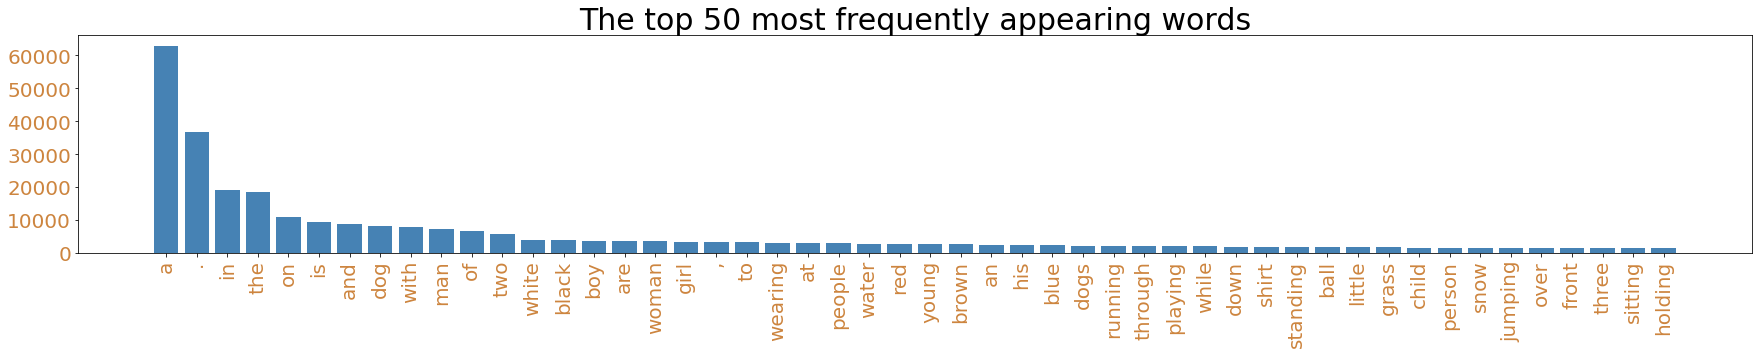

In [28]:
plot_hist(dfwordcount.iloc[:topn,:],title="The top 50 most frequently appearing words")

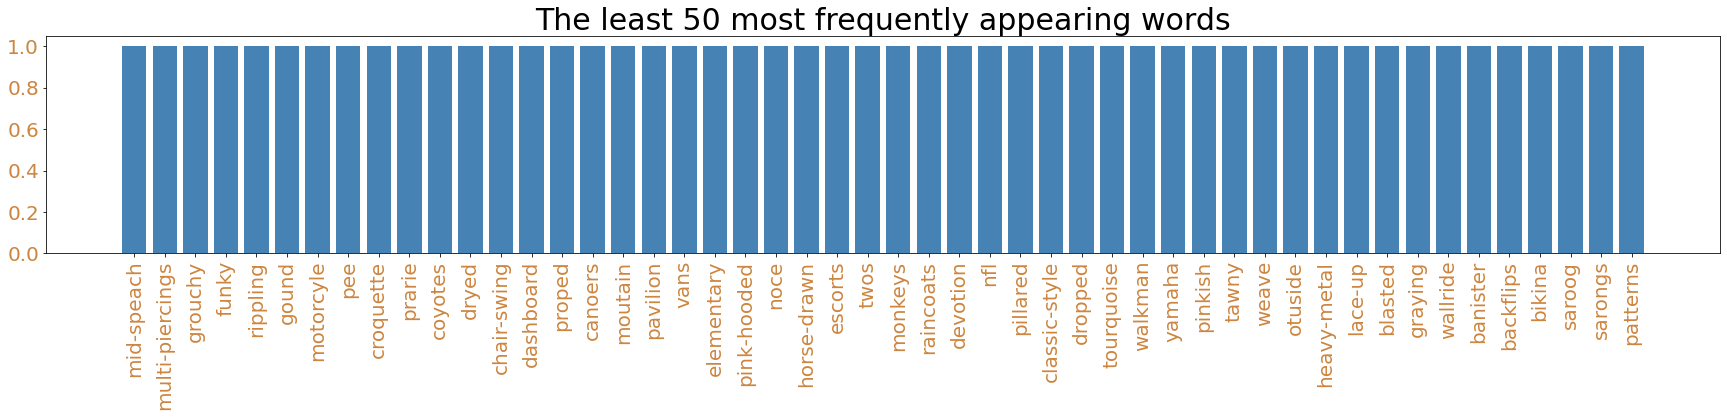

In [29]:
plot_hist(dfwordcount.iloc[-topn:,:],title="The least 50 most frequently appearing words")

Here we can observe the most frequent words are 'a','.','in','the', etc which are __articles__, __punctuations__, or __one charcater word__. These type of words dont have any importance for the data.

So we will remove this words to get clean data.

In [30]:
# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

In [31]:
# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)


In [32]:
# To remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [33]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(caption_df.caption.values):
    newcaption = text_clean(caption)
    caption_df["caption"].iloc[i] = newcaption

In [34]:
clean_vocabulary = create_vocabulary(caption_df)

Vocabulary Size : 8357


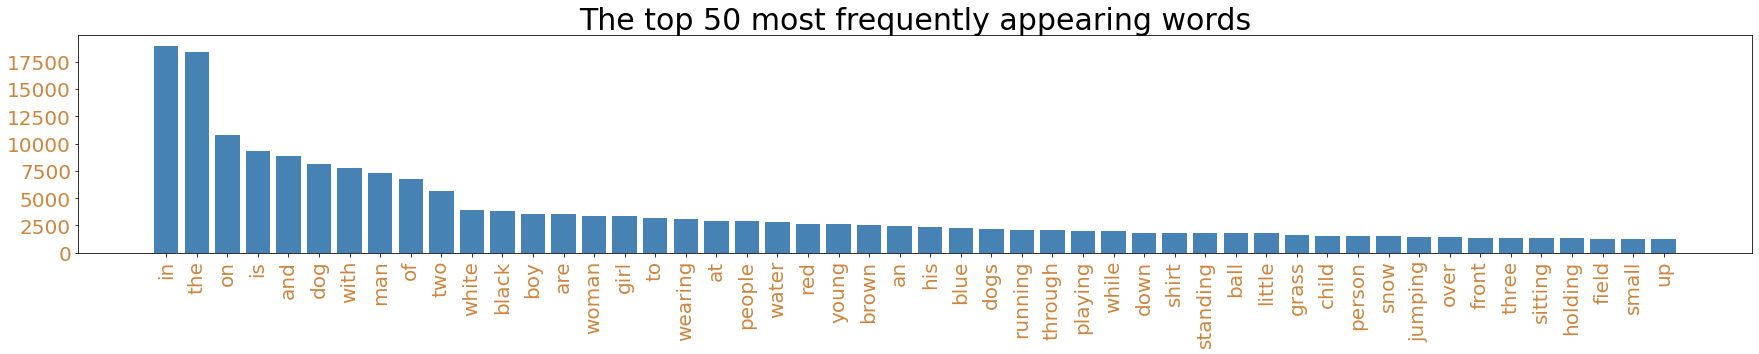

In [35]:
dfwordcount = df_word_count(caption_df,clean_vocabulary)
plot_hist(dfwordcount.iloc[:topn,:],title="The top 50 most frequently appearing words")

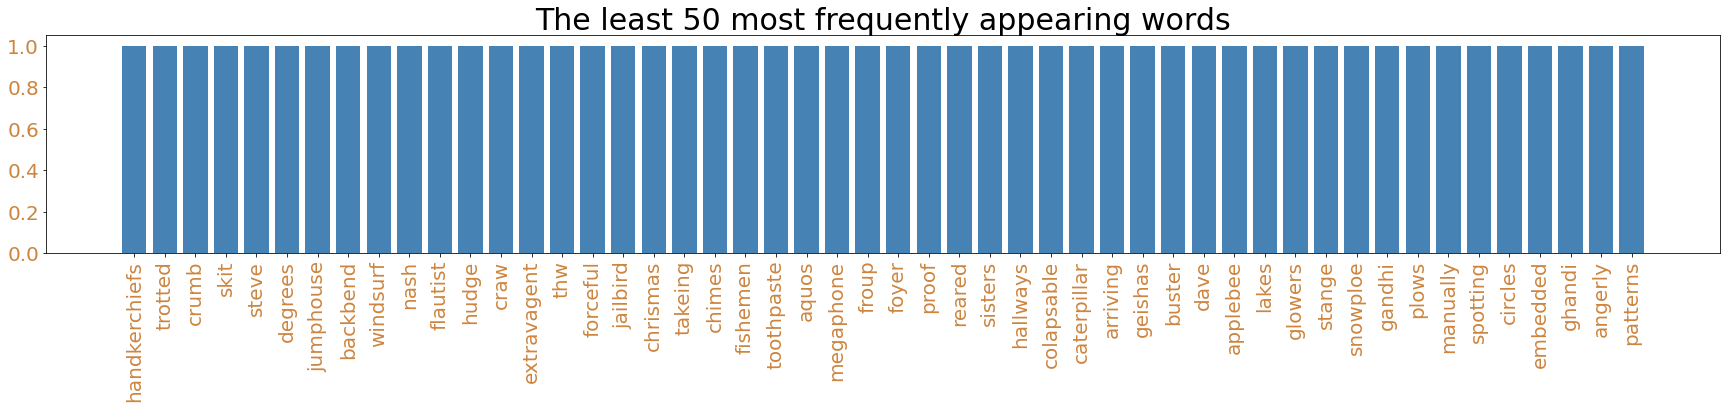

In [36]:
plot_hist(dfwordcount.iloc[-topn:,:],title="The least 50 most frequently appearing words")

#### Preprocessing the images

Here we are setting the path for each image so that we can load the images at once using the path set

In [37]:
def preprocess_images(data): 
    all_img_name_vector = []

    for filenames in data["filename"]:    
        full_image_path = images_path+"/"+ filenames
        all_img_name_vector.append(full_image_path)
    return all_img_name_vector


In [38]:
all_img_name_vector = preprocess_images(caption_df)
all_img_name_vector[:11]

['C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1000268201_693b08cb0e.jpg',
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1000268201_693b08cb0e.jpg',
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1000268201_693b08cb0e.jpg',
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1000268201_693b08cb0e.jpg',
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1000268201_693b08cb0e.jpg',
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1001773457_577c3a7d70.jpg',
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1001773457_577c3a7d70.jpg',
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1001773457_577c3a7d70.jpg',
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1001773457_577c3a7d70.jpg',
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//10017734

#### Preprocessing the captions

Here we will be adding '__< start >' and '< end >__' tags to every caption, so that out ML model understands the starting and ending of each caption.

In [39]:
def add_start_end_tag(caption_df):
    total_captions = []
    
    for caption  in caption_df["caption"].astype(str):  
        caption = '<start> ' + caption+ ' <end>'
        total_captions.append(caption)
    return total_captions

In [40]:
total_captions = add_start_end_tag(caption_df)
total_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [41]:
ten_images = all_img_name_vector[:50]
unique_images = np.unique(ten_images)
print(unique_images)

['C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1000268201_693b08cb0e.jpg'
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1001773457_577c3a7d70.jpg'
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1002674143_1b742ab4b8.jpg'
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1003163366_44323f5815.jpg'
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1007129816_e794419615.jpg'
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1007320043_627395c3d8.jpg'
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1009434119_febe49276a.jpg'
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1012212859_01547e3f17.jpg'
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1015118661_980735411b.jpg'
 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1015584366_dfcec3

 Here,each image repeats 5 times in dataset so we will take only one by using unique method

In [42]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(ten_images):
    fig = figure()
    number_of_files = len(ten_images)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(ten_images[i])
        imshow(image,cmap='Greys_r', aspect='equal', interpolation='nearest')
        axis('off')

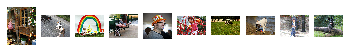

In [43]:
showImagesHorizontally(unique_images)

In [44]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 40455
Total Captions : 40455


In [45]:
def caption_df_limiter(num,total_captions,all_img_name_vector):   
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

In [46]:
train_captions,img_name_vector = caption_df_limiter(40000,total_captions,all_img_name_vector)

In [47]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40000 , Total images = 40000


In [48]:
from pickle import dump

# save to file
dump(train_captions, open('captions.pkl', 'wb'))
dump(img_name_vector, open('img_names.pkl', 'wb'))

In [49]:
train_captions = load(open('captions.pkl', 'rb'))
img_name_vector = load(open('img_names.pkl', 'rb'))

In [50]:
print("Total Captions = {0} , Total images = {1}".format(len(train_captions),len(img_name_vector)))

Total Captions = 40000 , Total images = 40000


#### lets see some image shapes

In [51]:
def get_img_shape(image):
    img= plt.imread(image)
    print("Shape of the image ==> {0} is ==> {1}".format(image.split('//')[1],img.shape))

In [52]:
img_list=[]
for i in range(20):  
    img_list.append(img_name_vector[i])

In [53]:
for j in img_list: 
    get_img_shape(j)

Shape of the image ==> 1956678973_223cb1b847.jpg is ==> (500, 375, 3)
Shape of the image ==> 3256603992_67312b5a36.jpg is ==> (375, 500, 3)
Shape of the image ==> 2938747424_64e64784f0.jpg is ==> (375, 500, 3)
Shape of the image ==> 2831314869_5025300133.jpg is ==> (400, 500, 3)
Shape of the image ==> 516725192_c9cdd63878.jpg is ==> (274, 500, 3)
Shape of the image ==> 537559285_29be110134.jpg is ==> (375, 500, 3)
Shape of the image ==> 2172493537_128bc8b187.jpg is ==> (334, 500, 3)
Shape of the image ==> 2287023569_fd7a9c60b8.jpg is ==> (500, 354, 3)
Shape of the image ==> 3191805046_77c334b506.jpg is ==> (500, 333, 3)
Shape of the image ==> 2869491449_1041485a6b.jpg is ==> (350, 500, 3)
Shape of the image ==> 140377584_12bdbdf2f8.jpg is ==> (375, 500, 3)
Shape of the image ==> 132489044_3be606baf7.jpg is ==> (375, 500, 3)
Shape of the image ==> 2346401538_f5e8da66fc.jpg is ==> (322, 500, 3)
Shape of the image ==> 181157221_e12410ef0b.jpg is ==> (375, 500, 3)
Shape of the image ==> 31

Here, we can observe there are different shapes for different images

since we will be using VGG-16 model(transfer learning) let’s reshape the image size to 224x224x3 

Shape of the image:(333, 500, 3)


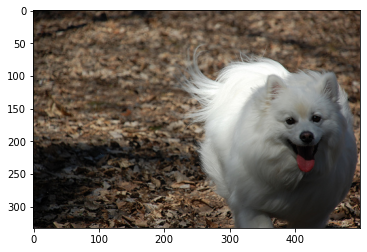

In [56]:
# To know the shape of images
def image_and_shapes(image):
    img= plt.imread(image)
    plt.imshow(img)
    print("Shape of the image:{}".format(img.shape))

image_and_shapes(r"C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset/3439243433_d5f3508612.jpg")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (224, 224, 3)


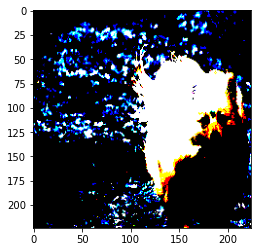

In [58]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

img1,img1_path = load_image(r"C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset/3439243433_d5f3508612.jpg")
print("Shape after resize :", img1.shape)
plt.imshow(img1)

Now we will be using image histograms. 
Histogram is considered as a graph or plot which is related to frequency of pixels in an Gray Scale Image
with pixel values (ranging from 0 to 255). Grayscale image is an image in which the value of each pixel is a single sample, that is, it carries only intensity information where pixel value varies from 0 to 255. 

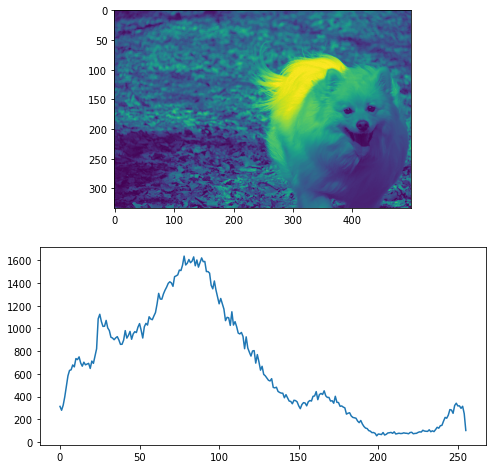

In [59]:
# importing required libraries of opencv 
import cv2 
# importing library for plotting 
from matplotlib import pyplot as plt 
def plot_image_histograms(image): 
  # reads an input image 
  img = cv2.imread(image,0) 
  # find frequency of pixels in range 0-255 
  histr = cv2.calcHist([img],[0],None,[256],[0,256]) 
    
  # show the plotting graph of an image 
  fig = plt.figure(figsize=(8, 8))
  plt.subplot(2,1,1)
  plt.imshow(img)
  plt.subplot(2,1,2)
  plt.plot(histr) 
  plt.show() 

plot_image_histograms(r"C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset/3439243433_d5f3508612.jpg")

## Pre-Trained Image Model (VGG16)


The following creates an instance of the VGG16 model using the Keras API.

The VGG16 model was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected (or dense) part which is used for the image classification.

In [60]:
import tensorflow as tf
modelvgg = tf.keras.applications.VGG16(include_top=True,weights=None) 

If include_top=True then the whole VGG16 model is downloaded which is about 528 MB. If include_top=False then only the convolutional part of the VGG16 model is downloaded which is just 57 MB.

In [61]:
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We do not need to classify the images here, we only need to extract an image vector for our images. Hence we remove the softmax layer from the model. 

Normally, the CNN's last layer is the softmax layer, which assigns the probability that each object might be in the image. But, if we remove that softmax layer from CNN, we can feed the CNN's rich encoding of the image into the DECODER(language generation of RNN) designed to produce phrases. We can then train the whole system directly on images and their captions, so it maximizes the likelihood that the descriptions it produces best match the training descriptions for each image

In [62]:
image_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
#The include_top argument is set to False, which means that the final fully connected layer(s) of the model will be excluded.
#The weights argument is set to 'imagenet', which means that the model will be initialized with pre-trained weights on the ImageNet dataset.
new_input = image_model.input # Any arbitrary shapes with 3 channels
hidden_layer = image_model.layers[-1].output
#The final line of code hidden_layer = image_model.layers[-1].output creates a new layer 
#that outputs the activations of the last layer of the VGG16 model. This layer will be used as the feature vector for each image.

In [63]:
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [64]:
image_features_extract_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Features extractraction from VGG16


In [65]:
# Get unique images
encode_train = sorted(set(img_name_vector))
#encode_train contains a list of all unique image names in the training 
print(encode_train[:10])

['C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1000268201_693b08cb0e.jpg', 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1001773457_577c3a7d70.jpg', 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1002674143_1b742ab4b8.jpg', 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1003163366_44323f5815.jpg', 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1007129816_e794419615.jpg', 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1007320043_627395c3d8.jpg', 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1009434119_febe49276a.jpg', 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1012212859_01547e3f17.jpg', 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1015118661_980735411b.jpg', 'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1015584366_dfcec3

In [66]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
for files in image_dataset: 
    print(files.numpy())

b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1000268201_693b08cb0e.jpg'
b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1001773457_577c3a7d70.jpg'
b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1002674143_1b742ab4b8.jpg'
b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1003163366_44323f5815.jpg'
b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1007129816_e794419615.jpg'
b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1007320043_627395c3d8.jpg'
b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1009434119_febe49276a.jpg'
b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1012212859_01547e3f17.jpg'
b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1015118661_980735411b.jpg'
b'C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset//1015584366_dfcec3

#### Map each image name to the function to load the image  

In [67]:
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [68]:
image_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

Now, we can see all the images has been reshapes to (224,224,3) which is required for VGG-16 model

We extract the features and store them in the respective .npy files and then pass those features through the encoder.

An NPY file is a NumPy array file created by the Python software package with the NumPy library installed. It contains an array saved in the NumPy (NPY) file format. NPY files store all the information required to reconstruct an array on any computer, which includes dtype and shape information.

In [69]:
from tqdm import tqdm

In [70]:
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [30:34<00:00, 14.44s/it]


In [71]:
np_img =np.load(r"C:\\Users\\Bhanu Koushik\\Downloads\\DEEPLEARNING_DS\\Flickr8k_Dataset/3338291921_fe7ae0c8f8.jpg.npy")


### Data Preparation for a Language Generation(RNN) DECODER
 

Here we will tokenise the captions and create vocabulary of unique words present in our data corpus. Next, we will limit the vocabulary size to top 5000 words to save memory. We will replace all the other words with the token < unk > (for words not in vocabulary). we will create a word->index mapping and vice versa.
We will pad all sequences to be the same length as the longest one.

Tokenizing the captions and creating vocabulary

In [72]:
def tokenize_caption(top_k,train_captions):
    # Choose the top 5000 words from the vocabulary
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
    # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls

    tokenizer.fit_on_texts(train_captions)
    train_seqs = tokenizer.texts_to_sequences(train_captions)

    # Map '<pad>' to '0'
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    
    # Create the tokenized vectors
    train_seqs = tokenizer.texts_to_sequences(train_captions)
    return train_seqs, tokenizer

In [73]:
train_seqs , tokenizer = tokenize_caption(5000,train_captions)

In [74]:
train_captions[:4]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>',
 '<start>  young man relaxing his legs on pice of machinery <end>']

In [75]:
train_seqs[:4]

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3],
 [2, 26, 11, 1463, 29, 344, 6, 1, 12, 1, 3]]

Here we can see that the sentences are converted to sequences and the sequences are of different length. So, we need pad the sequences to the maximum length of the captions.

In [76]:
# oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
tokenizer.oov_token

'<unk>'

In [77]:
tokenizer.index_word

{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'at',
 23: 'people',
 24: 'water',
 25: 'red',
 26: 'young',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'shirt',
 38: 'standing',
 39: 'ball',
 40: 'little',
 41: 'grass',
 42: 'child',
 43: 'person',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'front',
 48: 'three',
 49: 'sitting',
 50: 'holding',
 51: 'field',
 52: 'small',
 53: 'up',
 54: 'by',
 55: 'large',
 56: 'green',
 57: 'one',
 58: 'group',
 59: 'yellow',
 60: 'her',
 61: 'walking',
 62: 'children',
 63: 'men',
 64: 'into',
 65: 'air',
 66: 'beach',
 67: 'near',
 68: 'mouth',
 69: 'jumps',
 70: 'another',
 71: 'for',
 72: 'street',
 73: 'its',
 74: 'runs',
 75: 'from

In [78]:
tokenizer.word_counts

OrderedDict([('<start>', 40000),
             ('several', 308),
             ('children', 1136),
             ('leaping', 138),
             ('into', 1067),
             ('pile', 74),
             ('of', 6632),
             ('leaves', 139),
             ('on', 10622),
             ('the', 18232),
             ('ground', 355),
             ('<end>', 40000),
             ('man', 7193),
             ('hiking', 63),
             ('in', 18771),
             ('wilderness', 6),
             ('giving', 34),
             ('camera', 685),
             ('thumbs', 19),
             ('up', 1244),
             ('white', 3896),
             ('dog', 8046),
             ('is', 9266),
             ('running', 2049),
             ('through', 2012),
             ('water', 2757),
             ('onto', 211),
             ('shore', 169),
             ('young', 2598),
             ('relaxing', 15),
             ('his', 2327),
             ('legs', 130),
             ('pice', 1),
             ('machinery', 1),

Now, we can calculate the max and min length of captions

In [79]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [80]:
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

In [81]:
print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


Now, we will pad each vector to the max_length of the captions, so that all caption vectors are of same length

In [82]:
def padding_train_sequences(train_seqs,max_length,padding_type):
    cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding=padding_type,maxlen=max_length)
    return cap_vector

In [83]:
padded_caption_vector = padding_train_sequences(train_seqs,max_length,'post')
print(padded_caption_vector.shape)

(40000, 33)


In [84]:
padded_caption_vector

array([[  2, 184,  62, ...,   0,   0,   0],
       [  2,  11, 588, ...,   0,   0,   0],
       [  2,  14,   9, ...,   0,   0,   0],
       ...,
       [  2,  19,   4, ...,   0,   0,   0],
       [  2,  16,   4, ...,   0,   0,   0],
       [  2, 153,   9, ...,   0,   0,   0]])

## Train-Test Split

In [85]:
img_name_train, img_name_test, caption_train, caption_test = train_test_split(img_name_vector,padded_caption_vector,test_size=0.2,random_state=0)

Created training and test set using an 80-20 split

In [86]:
print("Training Data : X = {0},Y = {1}".format(len(img_name_train), len(caption_train)))
print("Test Data : X = {0},Y = {1}".format(len(img_name_test), len(caption_test)))

Training Data : X = 32000,Y = 32000
Test Data : X = 8000,Y = 8000


we can see that from total 40000 images and captions 80% i.e 32000 are splitted into training set and the remaining 20% i.e 8000 are splitted into testing set.

In [87]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [88]:
def load_npy(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

We wrap the training data in a Tensorflow Dataset object so that it can be efficiently fetched and fed, one batch at a time, to the model during training.

In [89]:
def create_dataset(img_name_train,caption_train):
    dataset = tf.data.Dataset.from_tensor_slices((img_name_train, caption_train))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_npy, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [90]:
# Creating train and test dataset
dataset = create_dataset(img_name_train,caption_train)
test_dataset = create_dataset(img_name_test,caption_test)

In [91]:
embedding_dim = 256 #The size of the embedding vectors for the words in the captions.
units = 512 #The number of units in the LSTM layer of the decoder.
vocab_size = len(tokenizer.word_index) + 1 #8329
num_steps = len(img_name_train) // BATCH_SIZE  #500
EPOCHS = 20
# Shape from last layer of VGG-16 :(7,7,512)
# So, say there are 49 pixel locations now and each pixel is 512 dimensional
features_shape = 512
attention_features_shape = 49 

## CNN ENCODER (VGG-16) Model


Encoder: since the image encoding has already been done by the pre-trained vgg model, the Encoder here is very simple. It consists of a Linear layer that takes the pre-encoded image features and passes them on to the Decoder.

In [92]:
class VGG16_Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        #It takes in an input image tensor, which will be the output of the last convolutional layer of the VGG16 model, 
        #and passes it through a fully connected (Dense) layer with a ReLU activation function to produce a feature vector of shape (batch_size, 49, embedding_dim), where 49 is the number of pixel locations and embedding_dim is the desired size of the feature vector.
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x        

## RNN DECODER:


Sequence Decoder: this is a recurrent network built with GRUs. The captions are passed in as the input after first going through an Embedding layer.

In [93]:
def rnn_type(units):
    if tf.test.is_gpu_available():
        return tf.compat.v1.keras.layers.CuDNNLSTM(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')

## RNN DECODER WITH ATTENTION MECHANISM:


Attention: as the Decoder generates each word of the output sequence, the Attention module helps it to focus on the most relevant part of the image for generating that word.

In the RNN Decoder we will also define the __Attention Mechanism__. We will need the features from the __CNN ENCODER__ . This Attention Mechanism will return the __context vector__ and __attention weights__ over the time axis.

#### RNN DECODER and BAHDANAU ATTENTION(LOCAL ATTENTION) MECHANISM: 


In [94]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and 
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

#The attention mechanism used is the additive attention mechanism, which calculates a score for each location in the features tensor 
#by taking the dot product of the output of two separate dense layers and then passing the result through a tanh activation function. The score is then passed through a final dense layer and a softmax activation function to obtain the attention weights. 
#These weights are then used to calculate the context vector, which is a weighted sum of the features tensor.

class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # Implementing Attention Mechanism 
    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)
    


  def call(self, x, features, hidden):
    
    # features shape ==> (64,49,256) ==> Output from ENCODER
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)
    
    #The input x is passed through an embedding layer, and then concatenated with a context vector which is the 
    #result of an attention mechanism applied to the features output from the encoder.
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (64, 49, 1)
    # Attention Function
    '''e(ij) = f(s(t-1),h(j))'''
    ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''
    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
    # self.Uattn(features) : (64,49,512)
    # self.Wattn(hidden_with_time_axis) : (64,1,512)
    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
    # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score
    # you get 1 at the last axis because you are applying score to self.Vattn
    
    
    # Then find Probability using Softmax
    '''attention_weights(alpha(ij)) = softmax(e(ij))'''
    attention_weights = tf.nn.softmax(score, axis=1)
    # attention_weights shape == (64, 49, 1)

    
    # Give weights to the different pixels in the image
    ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) ''' 
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
    # context_vector shape after sum == (64, 256)
    
    
    # x shape after passing through embedding == (64, 1, 256)
    x = self.embedding(x)
    
    # x shape after concatenation == (64, 1,  512)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # Adding Dropout and BatchNorm Layers
    x= self.dropout(x)
    x= self.batchnormalization(x)
    # output shape == (64 * 512)
    x = self.fc2(x)
    # shape : (64 * 8329(vocab))
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

#### RNN DECODER and LUONG ATTENTION(GLOBAL ATTENTION) MECHANISM: 


In [95]:
''' To choose score type: 
  Enter 'dot' for dot score
  Enter 'general' for general score
  Enter 'concat' for concat score
'''
def score_choose():
  scoring_type= input('Enter the scoring method: ')
  return scoring_type

In [97]:
scoring_type=score_choose()

Enter the scoring method: general


In [98]:
class Rnn_Global_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size,scoring_type):
        super(Rnn_Global_Decoder, self).__init__()
        

        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        
        
        
        self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.wc = tf.keras.layers.Dense(units, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

        #For Attention
        self.wa = tf.keras.layers.Dense(units)
        self.wb = tf.keras.layers.Dense(units)
        
        #For Score 3 i.e. Concat score
        self.Vattn = tf.keras.layers.Dense(1)
        self.wd = tf.keras.layers.Dense(units, activation='tanh')

        self.scoring_type = scoring_type
        
#The model has an embedding layer, a GRU layer, and three dense layers. The output of the embedding layer is fed into the GRU layer, which outputs a sequence of hidden states.
#These hidden states are used to compute a score for each word in the source language using one of the three scoring methods: dot, general, and concat. 
#The scores are then used to compute an alignment vector, which is used to compute a context vector that is a weighted sum of the encoder output. 
#The context vector and the hidden state are concatenated and passed through the dense layers to produce the logits.
        
    def call(self, sequence, features,hidden):
        
        # features : (64,49,256)
        # hidden : (64,512)
        
        embed = self.embedding(sequence)
        # embed ==> (64,1,256) ==> decoder_input after embedding (embedding dim=256)
       
        output, state = self.gru(embed)       
        #output :(64,1,512)

        score=0
        
        #Dot Score as per paper(Dot score : h_t (dot) h_s') (NB:just need to tweak gru units to 256)
        '''----------------------------------------------------------'''
        if(self.scoring_type=='dot'):
          xt=output #(64,1,512)
          xs=features #(256,49,64)  
          score = tf.matmul(xt, xs, transpose_b=True) 
               
          #score : (64,1,49)

        '''----------------------------------------------------------'''

        # General Score as per Paper ( General score: h_t (dot) Wa (dot) h_s')
        '''----------------------------------------------------------'''
        if(self.scoring_type=='general'):
          score = tf.matmul(output, self.wa(features), transpose_b=True)
          # score :(64,1,49)
        '''----------------------------------------------------------'''
        
        # Concat score as per paper (score: VT*tanh(W[ht;hs']))    
        '''----------------------------------------------------------'''
        #https://www.tensorflow.org/api_docs/python/tf/tile
        if(self.scoring_type=='concat'):
          tiled_features = tf.tile(features, [1,1,2]) #(64,49,512)
          tiled_output = tf.tile(output, [1,49,1]) #(64,49,512)
          
          concating_ht_hs = tf.concat([tiled_features,tiled_output],2) ##(64,49,1024)
          
          tanh_activated = self.wd(concating_ht_hs)
          score =self.Vattn(tanh_activated)
          #score :(64,49,1), but we want (64,1,49)
          score= tf.squeeze(score, 2)
          #score :(64,49)
          score = tf.expand_dims(score, 1)
          
          #score :(64,1,49)
        '''----------------------------------------------------------'''
        '''----------------------------------------------------------'''



        # alignment vector a_t
        alignment = tf.nn.softmax(score, axis=2)
        # alignment :(64,1,49)

        # context vector c_t is the average sum of encoder output
        context = tf.matmul(alignment, features)
        # context : (64,1,256)
        
        # Combine the context vector and the LSTM output
        
        output = tf.concat([tf.squeeze(context, 1), tf.squeeze(output, 1)], 1)
        # output: concat[(64,1,256):(64,1,512)] = (64,768)

        output = self.wc(output)
        # output :(64,512)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(output)
        # logits/predictions: (64,8239) i.e. (batch_size,vocab_size))

        return logits, state, alignment

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [99]:
''' Type: 'global' for Luong's Attention Mechanism(Global Attention) 
    Type: 'local' for Bahdanau's Attention Mechanism(Local Attention) 
'''
attention_choice = input("Choose the type of Attention Mechanism you want to apply :")

Choose the type of Attention Mechanism you want to apply :local


In [100]:
if(attention_choice=='local'):
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

else:
    encoder = VGG16_Encoder(embedding_dim)
    decoder = Rnn_Global_Decoder(embedding_dim, units, vocab_size,scoring_type)


In [101]:
decoder

#### Difference between classic decoder and with Attention mechanism

Attention enhance the Image Caption performance. How?

In the absence of Attention, the Decoder treats all parts of the image equally while generating the output word.


At each timestep, the Attention module takes the encoded image as input along with the Decoder’s hidden state for the previous timestep.

It produces an Attention Score that assigns a weight to each pixel of the encoded image. The higher the weight for a pixel, the more relevant it is for the word to be output at the next timestep.

In [102]:
def Encoder_features(img_tensor, target):
    features = encoder(img_tensor)
    return features,target,img_tensor


for (batch, (img_tensor, target)) in enumerate(dataset):
    features,target,img_tensor= Encoder_features(img_tensor, target)

In [103]:
target.shape # (batch_size,max_length)

TensorShape([64, 33])

In [104]:
img_tensor.shape #(batch_size,attention_feature_shape,feature_shape)

TensorShape([64, 49, 512])

In [105]:
features.shape #(batch_size,attention_feature_shape,feature_shape)

TensorShape([64, 49, 256])

Next, we define the loss function and optimizers:

In [110]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## MODEL TRAINING

The ENCODER output, hidden state(initialised to 0) and the DECODER input(which is the '<start'> token) are passed to the DECODER.
The DECODER returns the predictions and the DECODER hidden state.
    
The DECODER hidden state is then passed back into the model and the predictions are used to calculate the loss. 

While training, we use the Teacher Forcing technique, to decide the next input of the DECODER.
    
Teacher Forcing is the technique where the target word is passed as the next input to the DECODER. This technique helps to learn the correct sequence or correct statistical properties fro the sequence, quickly.
    
Final step is to calculate the Gradient and apply it to the optimizer and backpropagate.

In [115]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

#The function first initializes the decoder's hidden state, then expands the <start> token into a tensor of size batch_size x 1 and passes it as the first input to the decoder.


    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
          # passing the features through the decoder
          #dec_input = tf.expand_dims(target[:, i], 1)
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            
#It then computes the features for the input image using the encoder, and runs the decoder for each token in the target sequence, using teacher forcing (i.e., using the true target sequence as input instead of the predicted sequence). 
#At each timestep, it computes the loss between the predicted token and the true token using the loss_function defined earlier.
   
    
    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

  #train_loss(loss)
  #train_accuracy(target, predictions)

    return loss, total_loss

In [116]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
      # passing the features through the decoder

      
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
      # predictions : (64,8329)
        loss += loss_function(target[:, i], predictions)
      
        predicted_id = tf.argmax(predictions[0])
        dec_input = tf.expand_dims([predicted_id]*BATCH_SIZE, 1)
 

    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

Next, we train the model

In [118]:
EPOCHS = 12
for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0 

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
#The train_step function is defined to take in an image tensor and its corresponding target caption. 
#This function performs a forward pass through the encoder and the decoder with teacher forcing, calculates the loss, and applies the gradients to update the trainable variables (encoder and decoder).
        

        if batch % 100 == 0:
            print ('Epoch {} Batch {}  -Loss:{:.4f}'.format(epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
   # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
#Since this is a multi-class classification problem (where we have a fixed set of words that we can use to generate a caption),
#the choice of sparse categorical cross-entropy loss function is appropriate.

    print ('Epoch {} Loss:{:.6f}'.format(epoch + 1, total_loss/num_steps))

    print ('Time taken for 1 epoch:{} sec\n'.format(time.time() - start))

Epoch 1 Batch 0  -Loss:0.6522
Time taken for 1 epoch 3.1821084022521973 sec

Epoch 1 Batch 100  -Loss:0.6265
Time taken for 1 epoch 230.4838523864746 sec

Epoch 1 Batch 200  -Loss:0.7616
Time taken for 1 epoch 454.58058500289917 sec

Epoch 1 Batch 300  -Loss:0.7748
Time taken for 1 epoch 655.0429203510284 sec

Epoch 1 Batch 400  -Loss:0.8606
Time taken for 1 epoch 855.4995687007904 sec

Epoch 1 Loss:0.769619
Time taken for 1 epoch:1053.8630993366241 sec

Epoch 2 Batch 0  -Loss:0.7654
Time taken for 1 epoch 2.8108983039855957 sec

Epoch 2 Batch 100  -Loss:0.6720
Time taken for 1 epoch 214.3868293762207 sec

Epoch 2 Batch 200  -Loss:0.6337
Time taken for 1 epoch 462.5271999835968 sec

Epoch 2 Batch 300  -Loss:0.7734
Time taken for 1 epoch 715.0917320251465 sec

Epoch 2 Batch 400  -Loss:0.8076
Time taken for 1 epoch 967.7994456291199 sec

Epoch 2 Loss:0.718664
Time taken for 1 epoch:1218.8257627487183 sec

Epoch 3 Batch 0  -Loss:0.6361
Time taken for 1 epoch 4.183161735534668 sec

Epoch 3

Let’s plot the error graph:



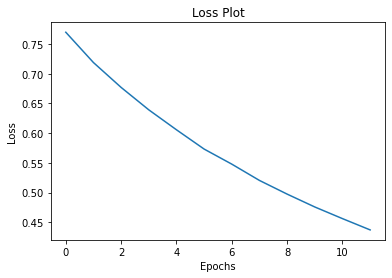

In [119]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Predicting and Evaluating the model

Greedy Approach

This is called as Maximum Likelihood Estimation (MLE) i.e. we select that word which is most likely according to the model for the given input. And sometimes this method is also called as Greedy Search, as we greedily select the word with maximum probability.

In [120]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0) # Start token is <start> for LSTM
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id]) # Store the result or word predicted

        if tokenizer.index_word[predicted_id] == '<end>': # if you reach <end> token then return the result
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) # Decoder input is the word predicted at previous timestep

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

we define a function to plot the attention and visualise the attention points that predicts the words

In [121]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [122]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_test))
image = r"C:\Users\Bhanu Koushik\Downloads\DEEPLEARNING_DS\Flickr8k_Dataset/2319175397_3e586cfaf8.jpg"

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = 'Two white dogs are playing in the snow'

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result


BELU score: 72.59795291154771
Real Caption: Two white dogs are playing in the snow
Prediction Caption: two white dogs are playing in the snow


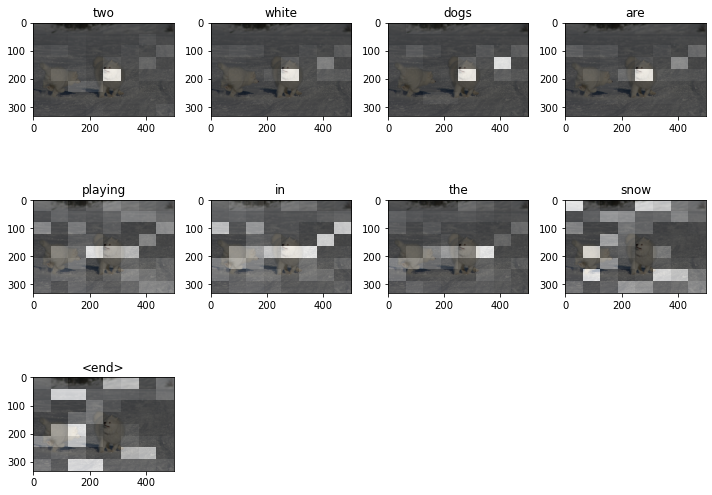

In [123]:
from nltk.translate.bleu_score import sentence_bleu

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

Real Caption: yellow dog chases red frisbee next to black pot
Prediction Caption: dog is jumping up to catch frisbee
BELU score: 0


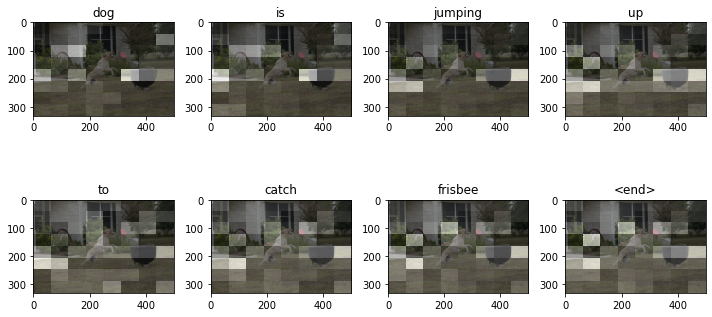

time took to Predict: 3 sec


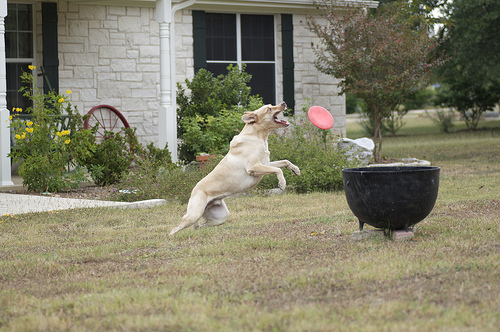

In [127]:
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)
#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(image)

Real Caption: four girls in evening wear are posing for photograph
Prediction Caption: women in dresses pose together and smile women hold hands


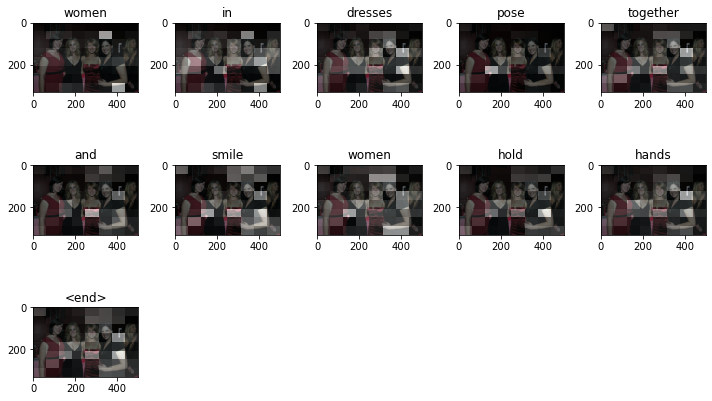

time took to Predict: 4 sec


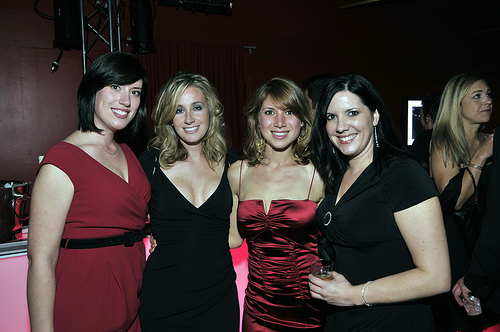

In [139]:
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)
#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)


plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(image)

Real Caption: small child in karate uniform is punching
Prediction Caption: young children are dancing in karate form and one hand
BELU score: 0


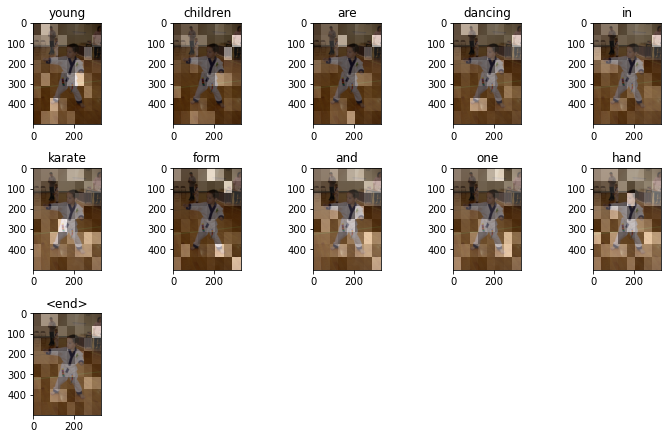

time took to Predict: 3 sec


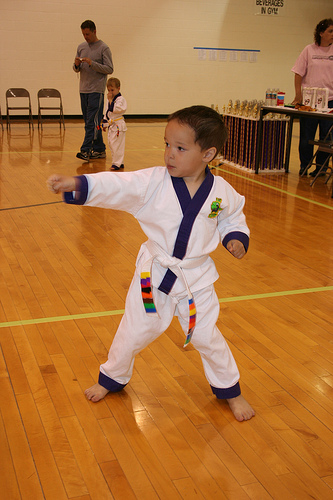

In [148]:
rid = np.random.randint(0, len(img_name_test))
image = img_name_test[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)
#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

# score = sentence_bleu(reference, candidate)
# print(f"BELU score: {score*100}")

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(image)

In [141]:
def pred(image_add):
    rid = np.random.randint(0, len(img_name_test))
#     image = img_name_test[rid]
    image=image_add

    start = time.time()
    real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

    #remove "<unk>" in result
    for i in result:
        if i=="<unk>":
            result.remove(i)
    #remove <end> from result        
    result_join = ' '.join(result)
    result_final = result_join.rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = result_final

    print ('Prediction Caption:', result_final)


    plot_attention(image, result, attention_plot)
    print(f"time took to Predict: {round(time.time()-start)} sec")

    return Image.open(image)

Prediction Caption: two white dogs are playing in the snow


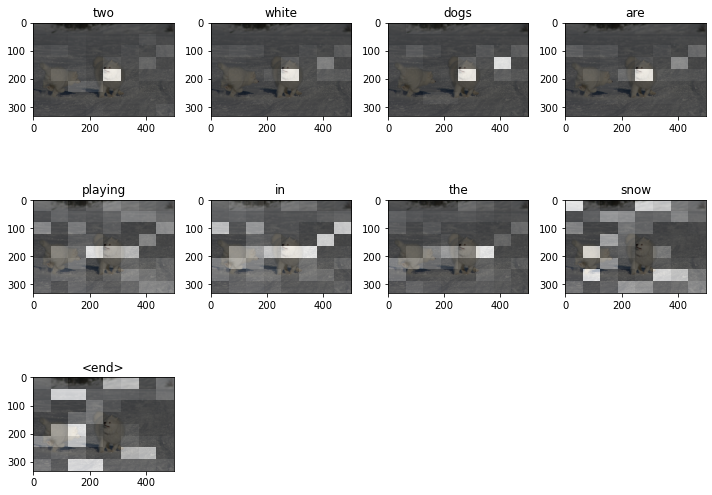

time took to Predict: 6 sec


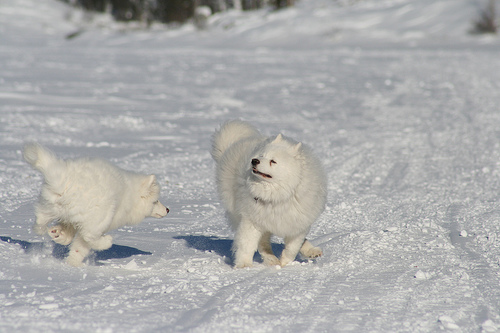

In [142]:
pred(r"C:\Users\Bhanu Koushik\Downloads\DEEPLEARNING_DS\Flickr8k_Dataset/2319175397_3e586cfaf8.jpg")

Prediction Caption: child in an all purple top is hanging upside down from tree


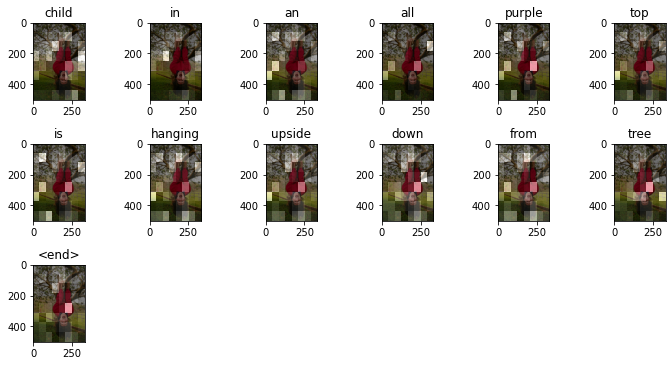

time took to Predict: 4 sec


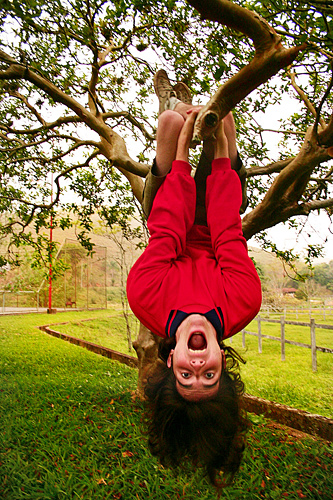

In [143]:
pred(r"C:\Users\Bhanu Koushik\Downloads\DEEPLEARNING_DS\Flickr8k_Dataset\262439544_e71cd26b24.jpg")

Prediction Caption: man in yellow vest works in the street


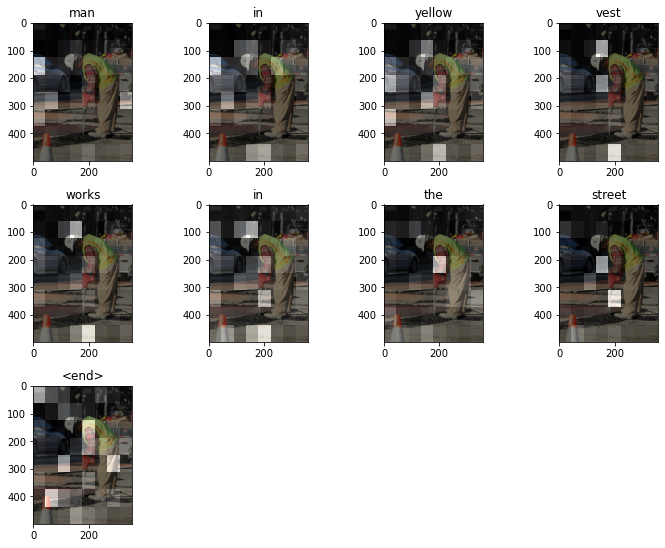

time took to Predict: 3 sec


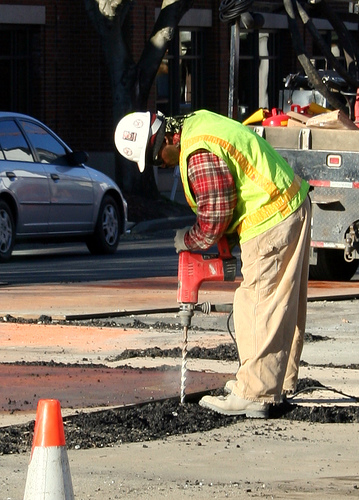

In [144]:
pred(r"C:\Users\Bhanu Koushik\Downloads\DEEPLEARNING_DS\Flickr8k_Dataset\405961988_fcfe97f31e.jpg")

Prediction Caption: young girl is on swing


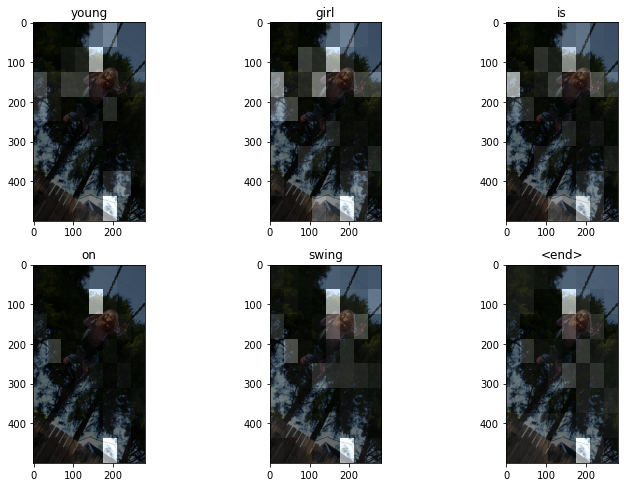

time took to Predict: 2 sec


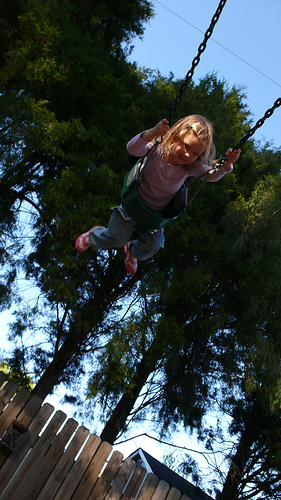

In [145]:
pred(r"C:\Users\Bhanu Koushik\Downloads\DEEPLEARNING_DS\Flickr8k_Dataset\463875230_f19e83d6df.jpg")

Prediction Caption: brown dog swims through water from the wall of water from the marketplace


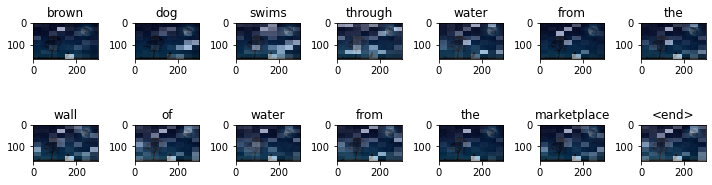

time took to Predict: 3 sec


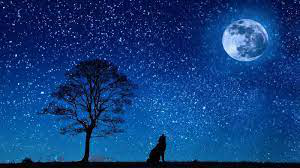

In [175]:
pred(r"C:\Users\Bhanu Koushik\OneDrive\Desktop\pic_download.jpg")

Prediction Caption: two dogs play with sticks out of brown and tan dog mouth open to catch something out of war


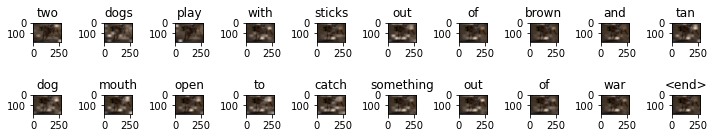

time took to Predict: 15 sec


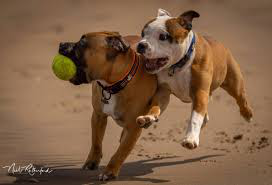

In [178]:
pred(r"C:\Users\Bhanu Koushik\OneDrive\Desktop\pic3_download.jpg")

Prediction Caption: some children playing soccer ball in the air


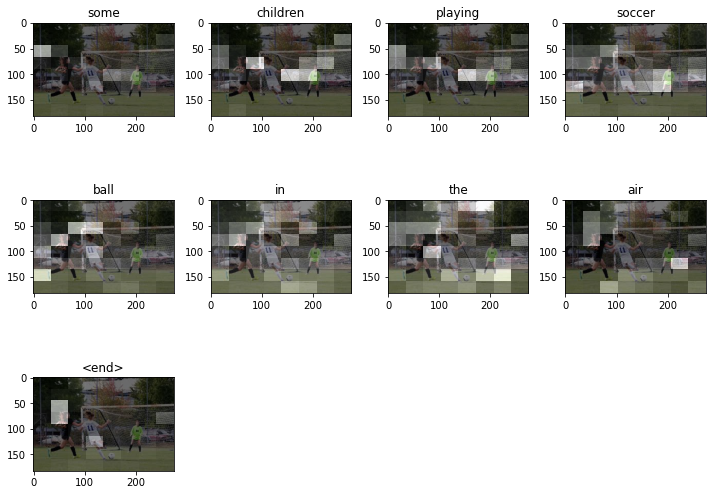

time took to Predict: 3 sec


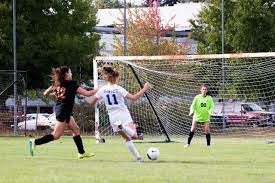

In [148]:
pred(r"C:\Users\Bhanu Koushik\Downloads\download.jpeg")